# Hedging Models Test - GBM Data

This notebook tests all hedging models on GBM-generated data:

1. **Data Generation**: Generate price paths using Geometric Brownian Motion
2. **Model Testing**: Test all deep and non-deep hedging models
3. **Visualization**: Plot GBM paths, delta positions, premiums, and evaluation metrics
4. **Evaluation**: Compute replication error and other relevant statistics


In [1]:
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

from src.models.parametric.gbm import GeometricBrownianMotion
from src.utils.preprocessing_utils import LogReturnTransformation

# Import deep hedgers
from src.hedging_models.deep_hedgers.feedforward_layers import FeedforwardLayers
from src.hedging_models.deep_hedgers.feedforward_time import FeedforwardTime
from src.hedging_models.deep_hedgers.lstm_hedger import LSTM
from src.hedging_models.deep_hedgers.rnn_hedger import RNN

# Import non-deep hedgers
from src.hedging_models.non_deep_hedgers.black_scholes import BlackScholes
from src.hedging_models.non_deep_hedgers.delta_gamma import DeltaGamma
from src.hedging_models.non_deep_hedgers.linear_regression import LinearRegression
from src.hedging_models.non_deep_hedgers.xgboost import XGBoost

print("Imports successful!")


Imports successful!


## Step 1: Generate GBM Data


In [ ]:
num_train_samples = 10000
num_test_samples = 2000
seq_length = 100
strike = 1.0
initial_price = 1.0
seed = 0

gbm = GeometricBrownianMotion()
dummy_log_returns = torch.randn(100, 20) * 0.02
gbm.fit(dummy_log_returns)

print(f"GBM Parameters:")
print(f"  mu (drift): {gbm.mu.item():.6f}")
print(f"  sigma (volatility): {gbm.sigma.item():.6f}")

train_log_returns = gbm.generate(num_train_samples, seq_length, seed=seed)
test_log_returns = gbm.generate(num_test_samples, seq_length, seed=seed + 1000)

print(f"\nGenerated data shapes:")
print(f"  Train log returns: {train_log_returns.shape}")
print(f"  Test log returns: {test_log_returns.shape}")

transformer = LogReturnTransformation()

train_prices = []
for i in range(num_train_samples):
    initial_val = torch.tensor(initial_price)
    prices = transformer.inverse_transform(train_log_returns[i], initial_val)
    train_prices.append(prices)
train_prices = torch.stack(train_prices)

test_prices = []
for i in range(num_test_samples):
    initial_val = torch.tensor(initial_price)
    prices = transformer.inverse_transform(test_log_returns[i], initial_val)
    test_prices.append(prices)
test_prices = torch.stack(test_prices)

print(f"\nPrice data shapes:")
print(f"  Train prices: {train_prices.shape}")
print(f"  Test prices: {test_prices.shape}")
print(f"  Price range: [{train_prices.min():.4f}, {train_prices.max():.4f}]")

Generating complicated log-returns data ...

Generated data shapes:
  Train log returns: torch.Size([10000, 100])
  Test log returns: torch.Size([2000, 100])

Price data shapes:
  Train prices: torch.Size([10000, 101])
  Test prices: torch.Size([2000, 101])
  Price range: [0.0040, 46.5507]
  Max jump magnitude in train set: 1.939
  Std of log returns (train): 0.1110


## Step 2: Visualize Sample GBM Paths


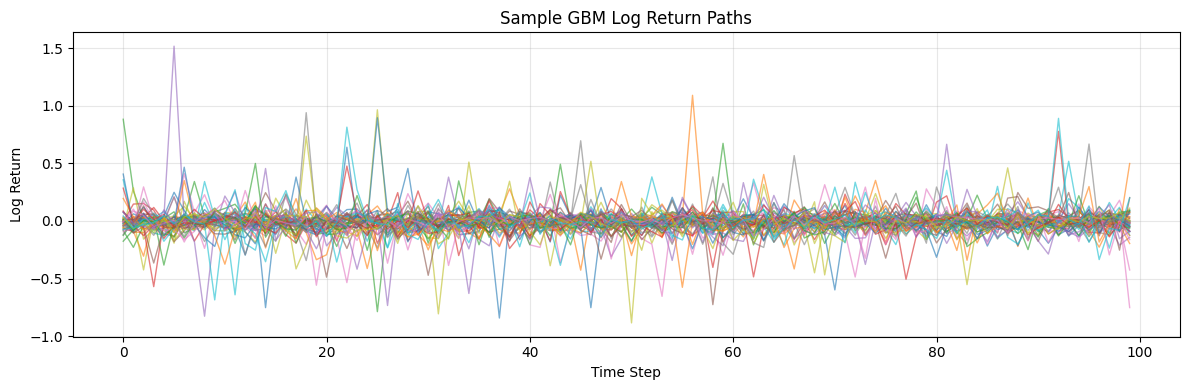

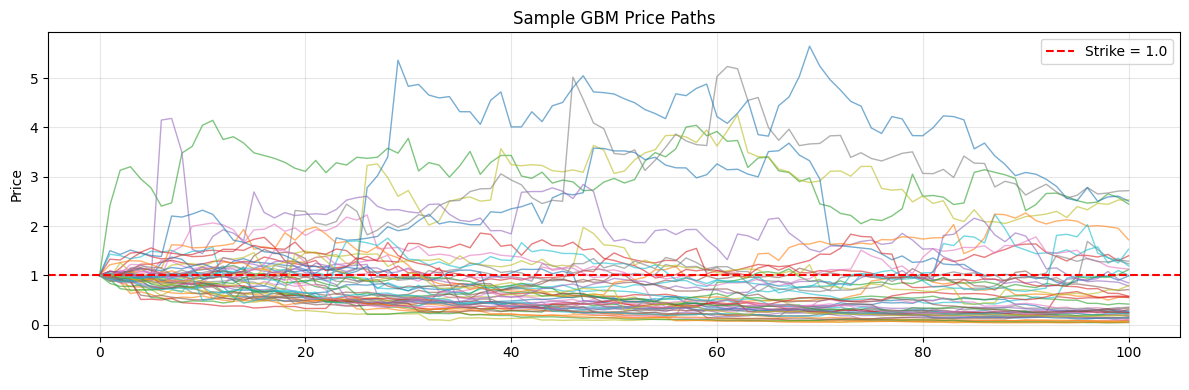

In [3]:
fig_lr, ax_lr = plt.subplots(figsize=(12, 4))
time_steps_lr = np.arange(seq_length)
np.random.seed(42)
sample_indices = np.random.choice(num_train_samples, 50, replace=False)

for idx in sample_indices:
    ax_lr.plot(time_steps_lr, train_log_returns[idx].cpu().numpy(), alpha=0.6, linewidth=1)

ax_lr.set_xlabel('Time Step')
ax_lr.set_ylabel('Log Return')
ax_lr.set_title('Sample GBM Log Return Paths')
ax_lr.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig_price, ax_price = plt.subplots(figsize=(12, 4))
time_steps_price = np.arange(seq_length + 1)
for idx in sample_indices:
    ax_price.plot(time_steps_price, train_prices[idx].cpu().numpy(), alpha=0.6, linewidth=1)

ax_price.axhline(y=strike, color='r', linestyle='--', label=f'Strike = {strike}')
ax_price.set_xlabel('Time Step')
ax_price.set_ylabel('Price')
ax_price.set_title('Sample GBM Price Paths')
ax_price.legend()
ax_price.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 3: Initialize and Train All Hedging Models


In [4]:
# Initialize all models
models = {}

# Deep hedgers
models['FeedforwardLayers'] = FeedforwardLayers(seq_length=seq_length, hidden_size=64, strike=strike)
models['FeedforwardTime'] = FeedforwardTime(seq_length=seq_length, hidden_size=64, strike=strike)
models['LSTM'] = LSTM(seq_length=seq_length, hidden_size=64, strike=strike, num_layers=2)
models['RNN'] = RNN(seq_length=seq_length, hidden_size=64, strike=strike, num_layers=2)

# Non-deep hedgers
models['BlackScholes'] = BlackScholes(seq_length=seq_length, strike=strike)
models['DeltaGamma'] = DeltaGamma(seq_length=seq_length, strike=strike)
models['LinearRegression'] = LinearRegression(seq_length=seq_length, strike=strike)
models['XGBoost'] = XGBoost(seq_length=seq_length, strike=strike, n_estimators=50, max_depth=7)

print(f"Initialized {len(models)} hedging models:")
for name in models.keys():
    print(f"  - {name}")


Initialized 8 hedging models:
  - FeedforwardLayers
  - FeedforwardTime
  - LSTM
  - RNN
  - BlackScholes
  - DeltaGamma
  - LinearRegression
  - XGBoost


In [5]:
# Train all models
training_results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    try:
        if 'Feedforward' in name or 'LSTM' in name or 'RNN' in name:
            # Deep hedgers: use more epochs
            model.fit(train_prices, num_epochs=200, batch_size=32, learning_rate=1e-3)
        else:
            # Non-deep hedgers: fewer epochs (or just fit once)
            model.fit(train_prices)
        
        training_results[name] = "Success"
        print(f"✓ {name} trained successfully")
    except Exception as e:
        training_results[name] = f"Error: {str(e)}"
        print(f"✗ {name} failed: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print("Training Summary:")
for name, result in training_results.items():
    status = "✓" if result == "Success" else "✗"
    print(f"  {status} {name}: {result}")



Training FeedforwardLayers
Epoch 1/200, Loss: 0.661536
Epoch 2/200, Loss: 0.470281
Epoch 3/200, Loss: 0.548384
Epoch 4/200, Loss: 0.490576
Epoch 5/200, Loss: 0.314740
Epoch 6/200, Loss: 0.906316
Epoch 7/200, Loss: 0.685824
Epoch 8/200, Loss: 1.098711
Epoch 9/200, Loss: 0.386732
Epoch 10/200, Loss: 2.736709
Epoch 11/200, Loss: 0.443506
Epoch 12/200, Loss: 0.165522
Epoch 13/200, Loss: 0.158764
Epoch 14/200, Loss: 0.302559
Epoch 15/200, Loss: 0.491161
Epoch 16/200, Loss: 0.485800
Epoch 17/200, Loss: 0.200187
Epoch 18/200, Loss: 0.182714
Epoch 19/200, Loss: 0.277731
Epoch 20/200, Loss: 0.199293
Epoch 21/200, Loss: 0.300080
Epoch 22/200, Loss: 0.245879
Epoch 23/200, Loss: 2.102071
Epoch 24/200, Loss: 5.433873
Epoch 25/200, Loss: 0.197986
Epoch 26/200, Loss: 0.626345
Epoch 27/200, Loss: 1.273981
Epoch 28/200, Loss: 4.928005
Epoch 29/200, Loss: 0.138420
Epoch 30/200, Loss: 0.280611
Epoch 31/200, Loss: 0.397293
Epoch 32/200, Loss: 0.419009
Epoch 33/200, Loss: 0.104057
Epoch 34/200, Loss: 0.13

## Step 4: Evaluate Models on Test Data


In [6]:
# Evaluate all models
evaluation_results = {}

for name, model in models.items():
    if training_results.get(name) != "Success":
        continue
    
    print(f"\nEvaluating {name}...")
    try:
        results = model.evaluate(test_prices)
        evaluation_results[name] = results
        print(f"  Premium: {results['premium']:.6f}")
        print(f"  Mean X (replication error): {results['mean_X']:.6f}")
        print(f"  Std X: {results['std_X']:.6f}")
        print(f"  MSE X: {results['mse_X']:.6f}")
    except Exception as e:
        print(f"  Error: {str(e)}")
        evaluation_results[name] = None

print(f"\n{'='*60}")
print("Evaluation Summary:")
print(f"{'='*60}")



Evaluating FeedforwardLayers...
  Premium: 0.470168
  Mean X (replication error): -0.003562
  Std X: 0.261254
  MSE X: 0.068232

Evaluating FeedforwardTime...
  Premium: 0.440033
  Mean X (replication error): 0.001204
  Std X: 0.114808
  MSE X: 0.013176

Evaluating LSTM...
  Premium: 0.414874
  Mean X (replication error): 0.013121
  Std X: 0.168678
  MSE X: 0.028610

Evaluating RNN...
  Premium: 0.446621
  Mean X (replication error): 0.003892
  Std X: 0.126370
  MSE X: 0.015977

Evaluating BlackScholes...
  Premium: 0.420966
  Mean X (replication error): 0.005086
  Std X: 0.136210
  MSE X: 0.018570

Evaluating DeltaGamma...
  Premium: 0.079656
  Mean X (replication error): -0.093396
  Std X: 0.627774
  MSE X: 0.402626

Evaluating LinearRegression...
  Premium: 0.456984
  Mean X (replication error): 0.007120
  Std X: 0.255506
  MSE X: 0.065301

Evaluating XGBoost...
  Premium: 0.214174
  Mean X (replication error): 0.157926
  Std X: 0.420743
  MSE X: 0.201877

Evaluation Summary:


In [7]:
# Create evaluation summary table
eval_data = []
for name, results in evaluation_results.items():
    if results is not None:
        eval_data.append({
            'Model': name,
            'Premium': results['premium'],
            'Mean_X': results['mean_X'],
            'Std_X': results['std_X'],
            'MSE_X': results['mse_X'],
            'Mean_Payoff': results['mean_payoff'],
            'Mean_Terminal_Value': results['mean_terminal_value']
        })

if eval_data:
    eval_df = pd.DataFrame(eval_data)
    print("\nEvaluation Metrics:")
    print(eval_df.to_string(index=False))



Evaluation Metrics:
            Model  Premium    Mean_X    Std_X    MSE_X  Mean_Payoff  Mean_Terminal_Value
FeedforwardLayers 0.470168 -0.003562 0.261254 0.068232     0.191713             0.195276
  FeedforwardTime 0.440033  0.001204 0.114808 0.013176     0.191713             0.190509
             LSTM 0.414874  0.013121 0.168678 0.028610     0.191713             0.178593
              RNN 0.446621  0.003892 0.126370 0.015977     0.191713             0.187821
     BlackScholes 0.420966  0.005086 0.136210 0.018570     0.191713             0.186628
       DeltaGamma 0.079656 -0.093396 0.627774 0.402626     0.191713             0.285110
 LinearRegression 0.456984  0.007120 0.255506 0.065301     0.191713             0.184594
          XGBoost 0.214174  0.157926 0.420743 0.201877     0.191713             0.033787


## Step 5: Compare Replication Errors

Computing replication errors for FeedforwardLayers...
Computing replication errors for FeedforwardTime...
Computing replication errors for LSTM...
Computing replication errors for RNN...
Computing replication errors for BlackScholes...
Computing replication errors for DeltaGamma...
Computing replication errors for LinearRegression...
Computing replication errors for XGBoost...


/var/folders/5g/xd1_vnlj2zg4df463t644sgw0000gn/T/ipykernel_59160/2032919422.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(error_data, labels=list(replication_errors.keys()), vert=True)


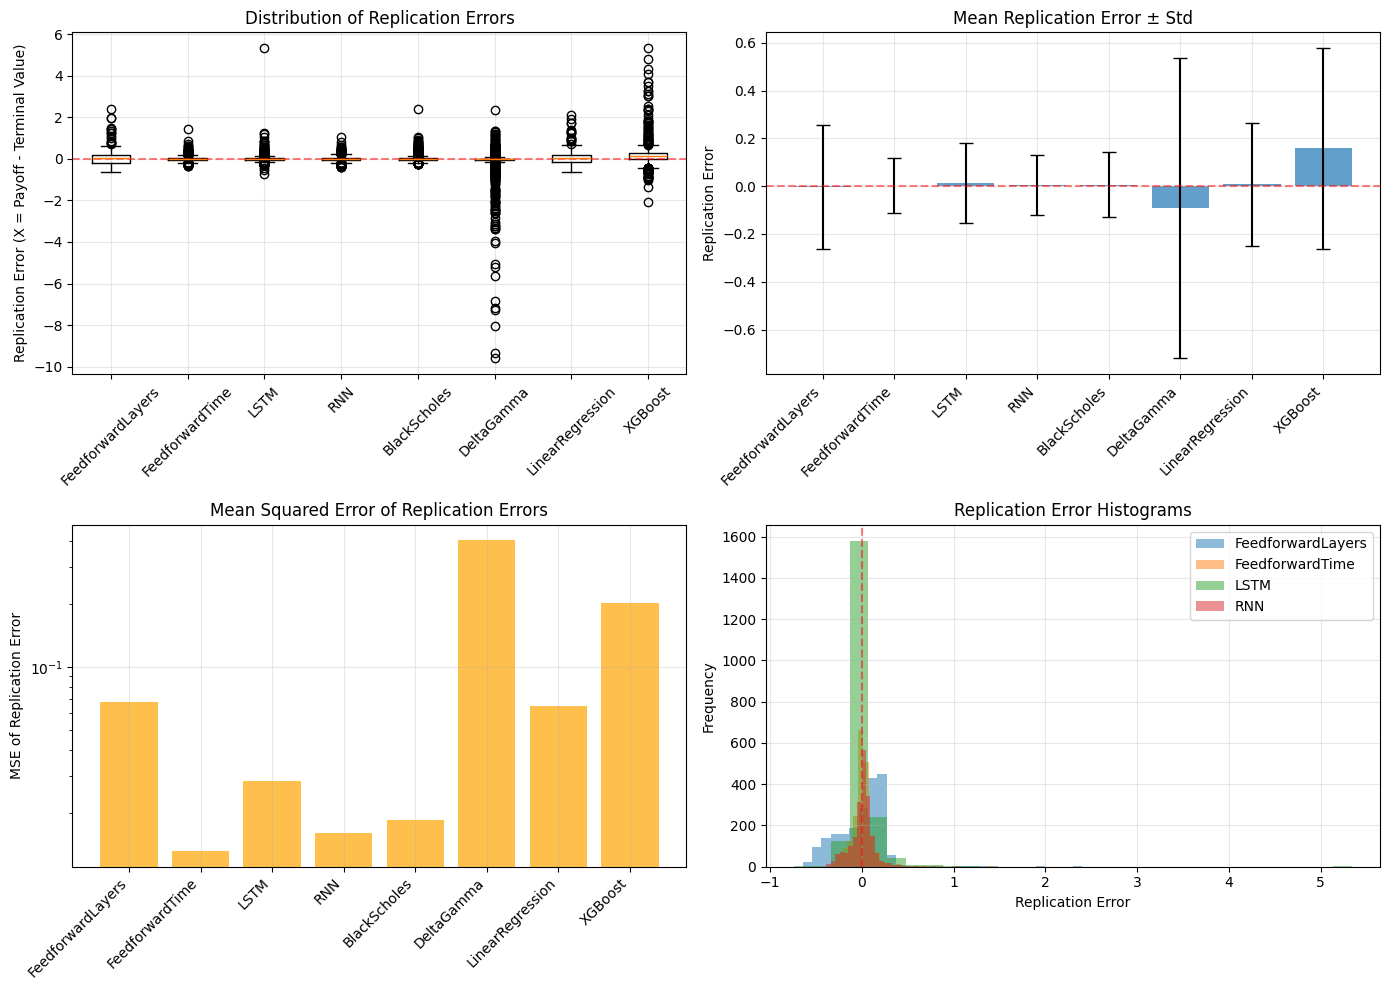

In [8]:
# Compute replication errors for all test samples
replication_errors = {}

for name, model in models.items():
    if name not in evaluation_results or evaluation_results[name] is None:
        continue
    
    print(f"Computing replication errors for {name}...")
    with torch.no_grad():
        deltas = model.forward(test_prices)
        terminal_values = model.compute_terminal_value(test_prices, deltas)
        final_prices = test_prices[:, -1]
        payoffs = model.compute_payoff(final_prices)
        X = payoffs - terminal_values
        replication_errors[name] = X.cpu().numpy()

# Plot replication error distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot 1: Box plot of replication errors
ax1 = axes[0]
error_data = [replication_errors[name] for name in replication_errors.keys()]
ax1.boxplot(error_data, labels=list(replication_errors.keys()), vert=True)
ax1.set_ylabel('Replication Error (X = Payoff - Terminal Value)')
ax1.set_title('Distribution of Replication Errors')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: Mean and Std of replication errors
ax2 = axes[1]
means = [np.mean(replication_errors[name]) for name in replication_errors.keys()]
stds = [np.std(replication_errors[name]) for name in replication_errors.keys()]
x_pos = np.arange(len(replication_errors.keys()))
ax2.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(list(replication_errors.keys()), rotation=45, ha='right')
ax2.set_ylabel('Replication Error')
ax2.set_title('Mean Replication Error ± Std')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 3: MSE of replication errors
ax3 = axes[2]
mses = [np.mean(replication_errors[name]**2) for name in replication_errors.keys()]
ax3.bar(x_pos, mses, alpha=0.7, color='orange')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(list(replication_errors.keys()), rotation=45, ha='right')
ax3.set_ylabel('MSE of Replication Error')
ax3.set_title('Mean Squared Error of Replication Errors')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Histogram comparison for a few models
ax4 = axes[3]
selected_models = list(replication_errors.keys())[:4]  # Select first 4
for name in selected_models:
    ax4.hist(replication_errors[name], bins=30, alpha=0.5, label=name)
ax4.set_xlabel('Replication Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Replication Error Histograms')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


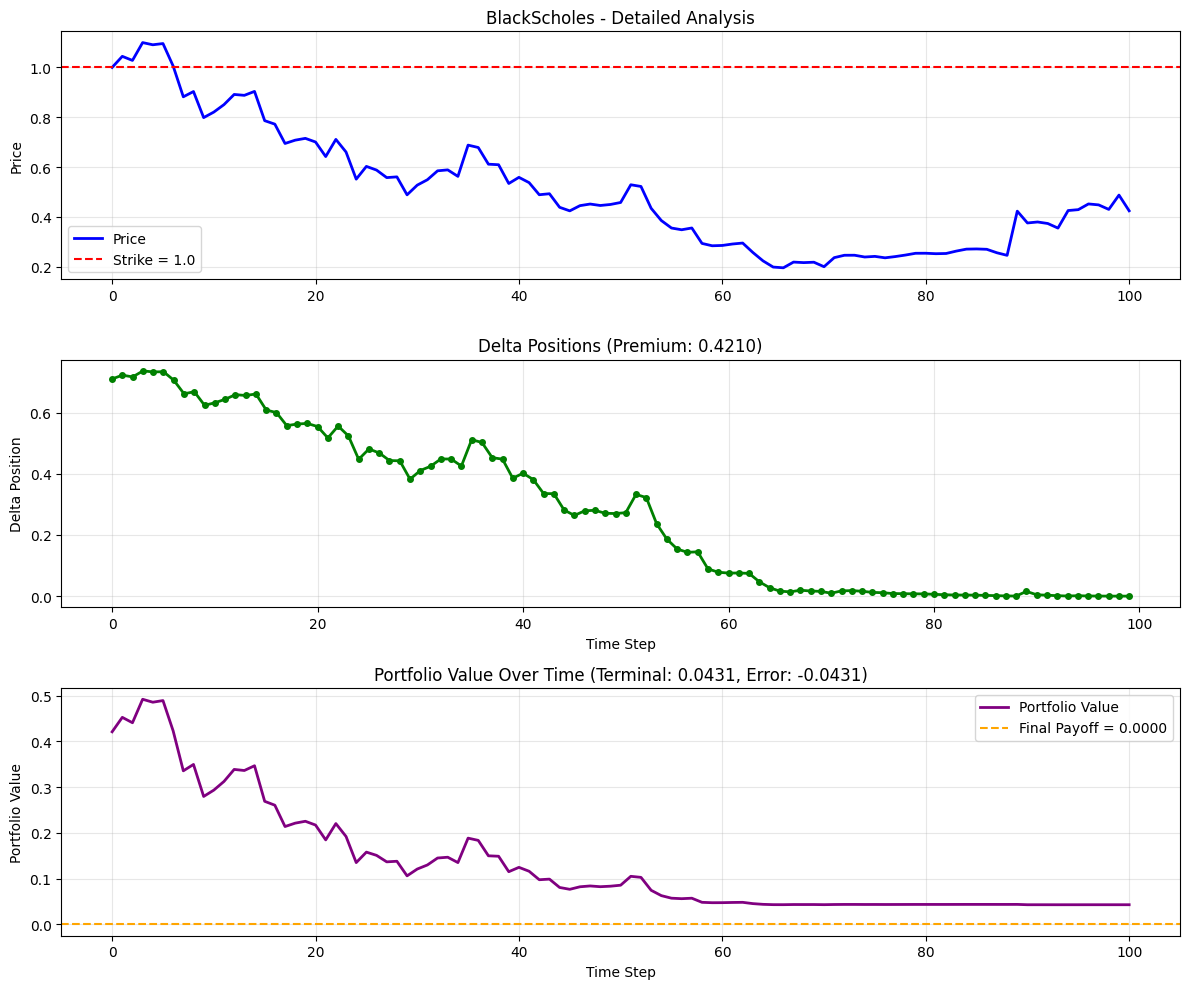

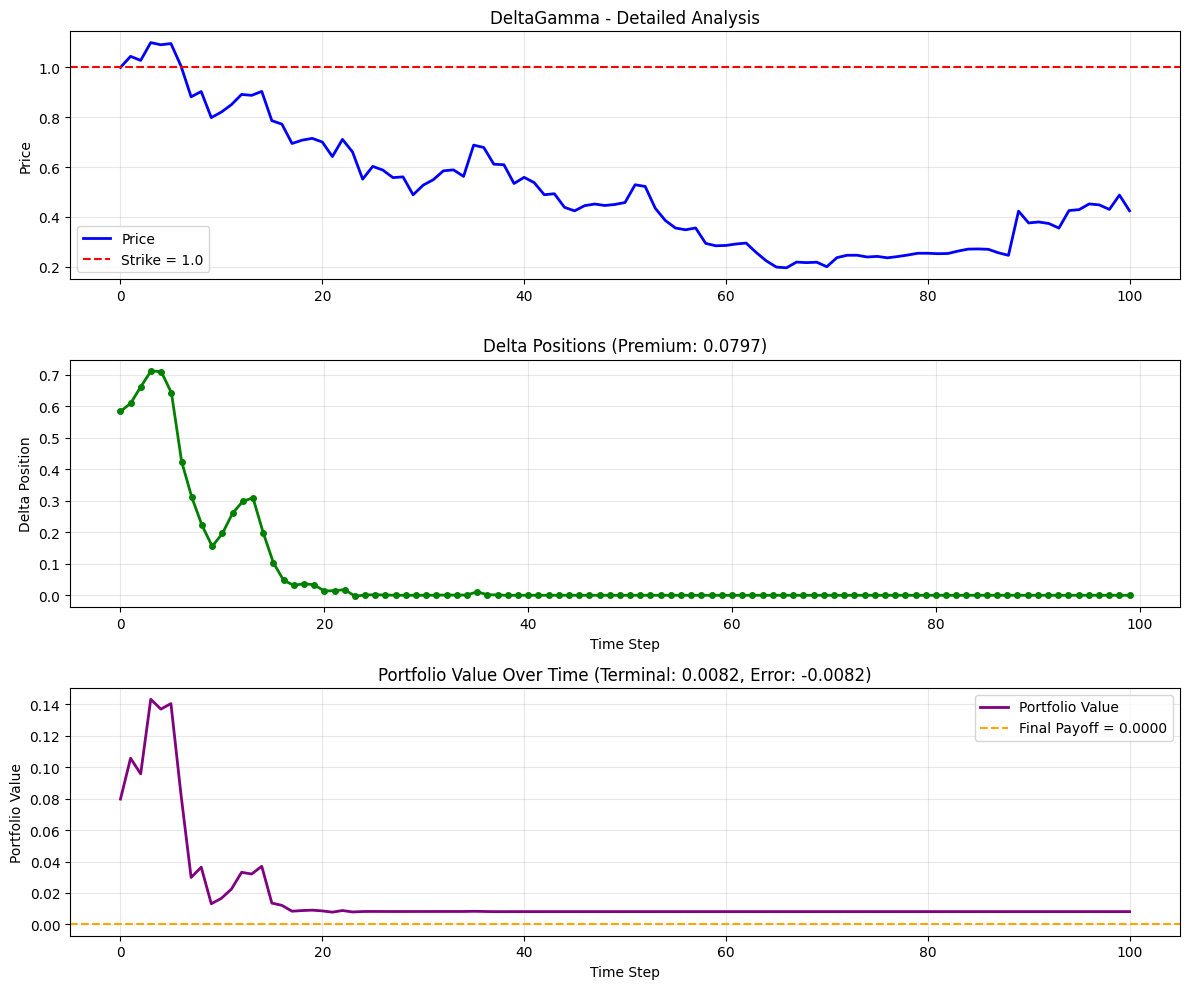

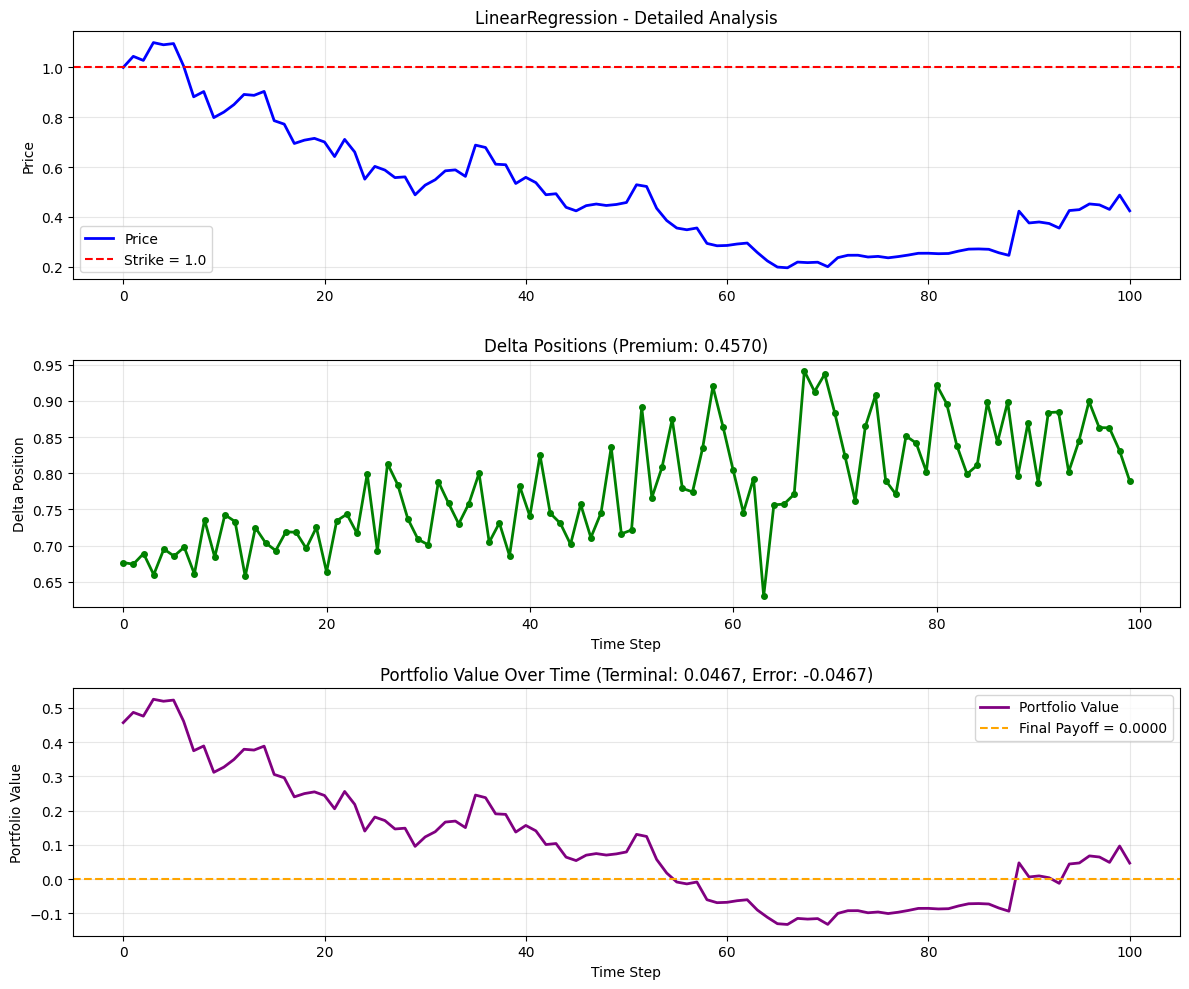

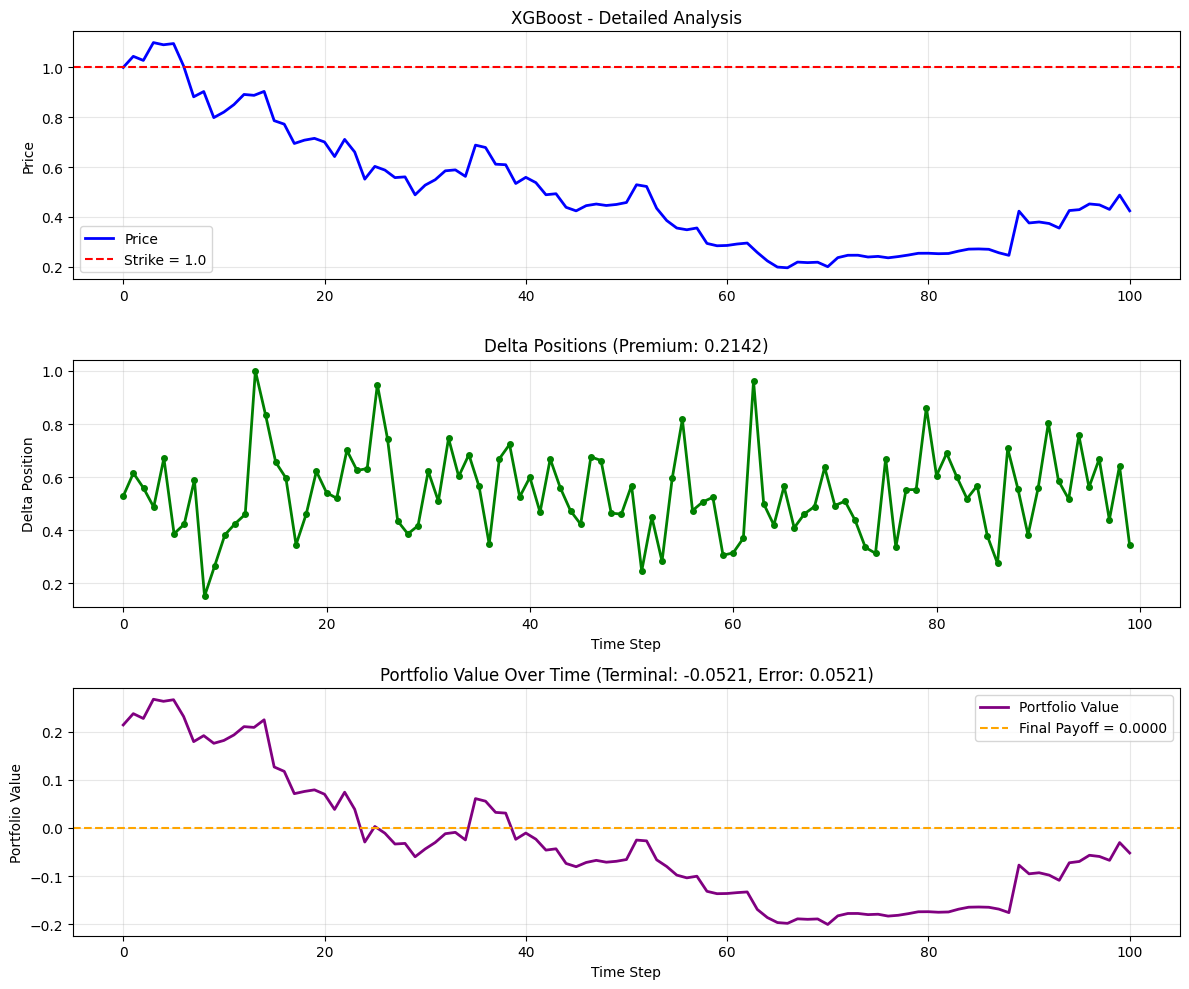

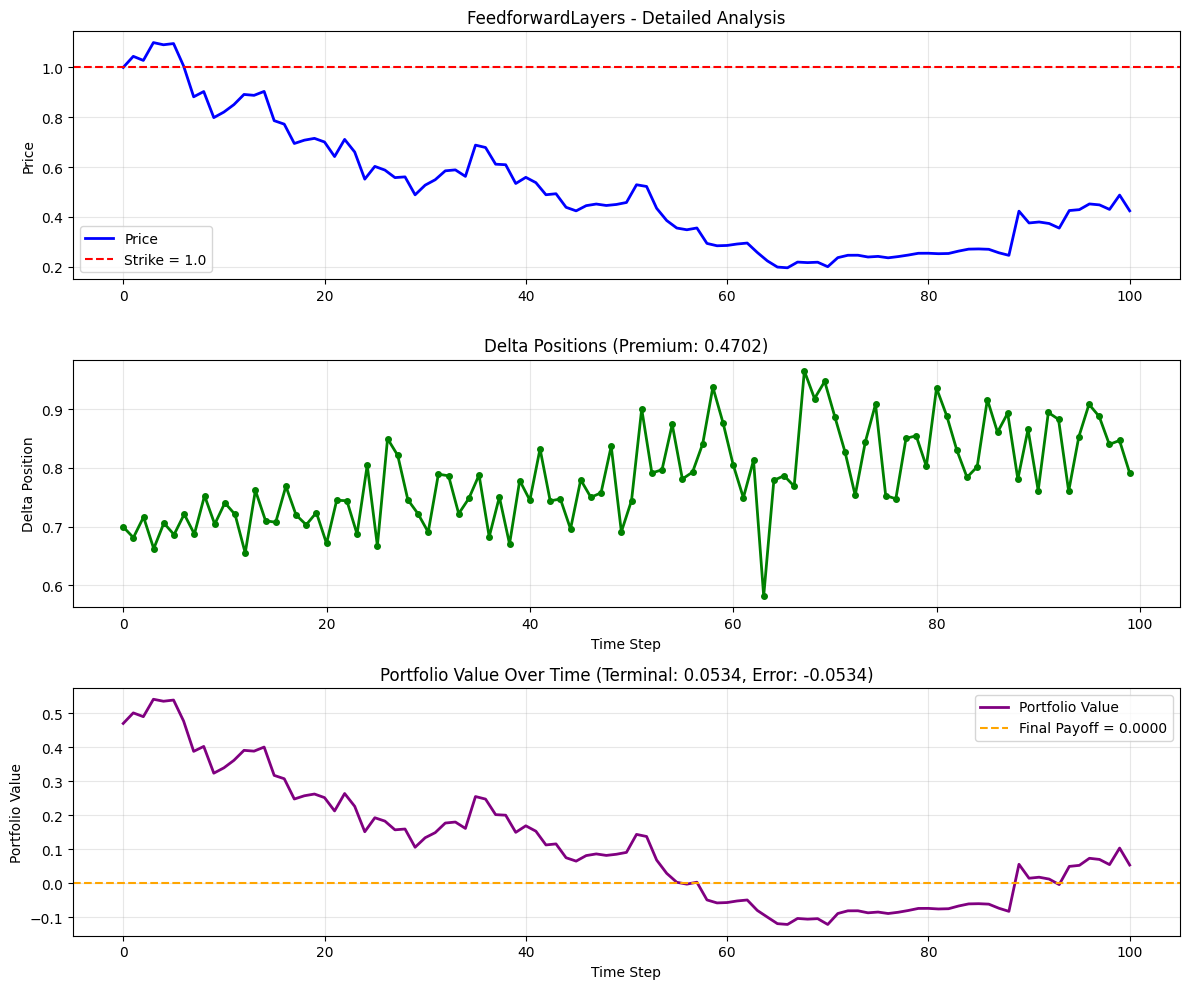

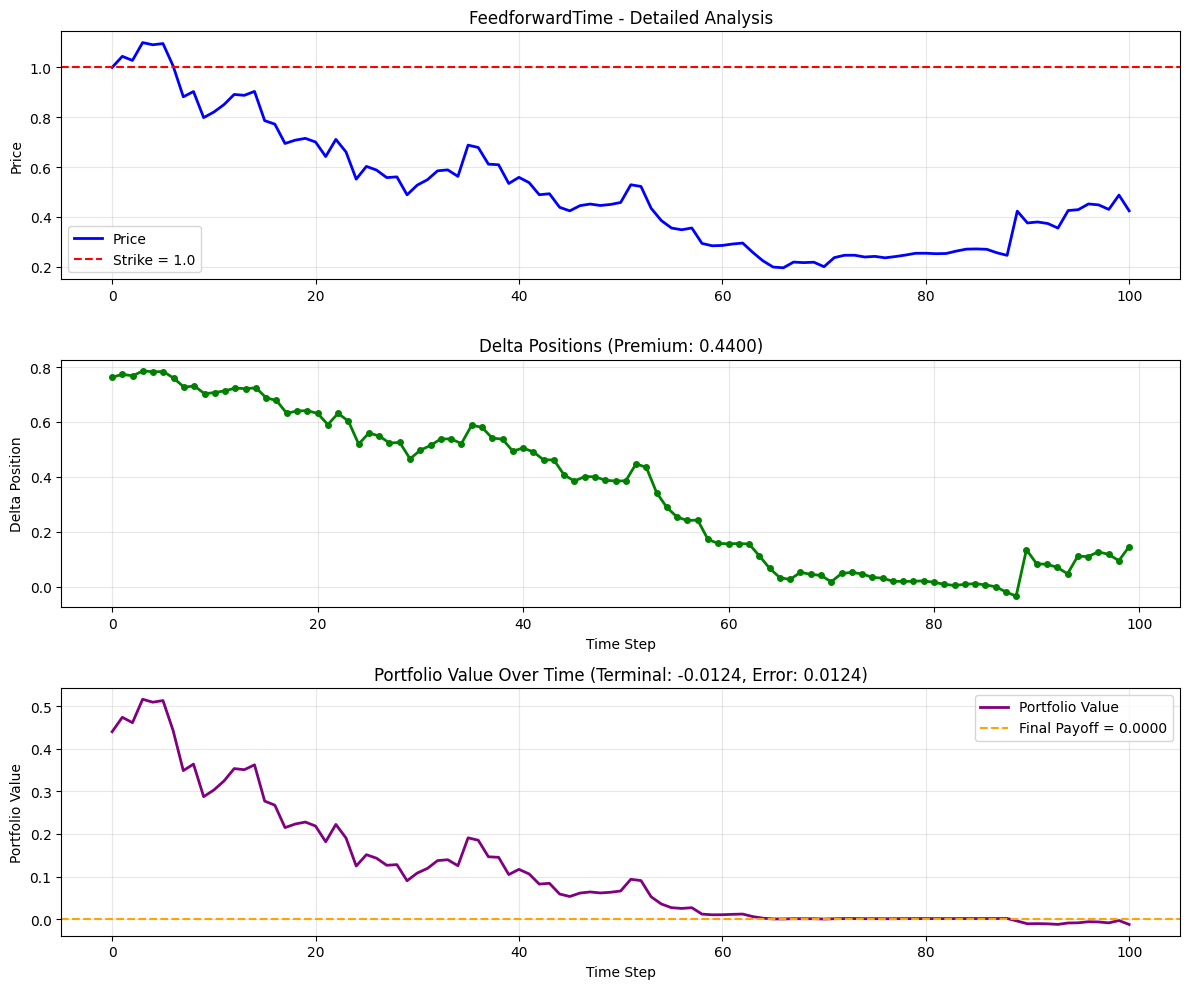

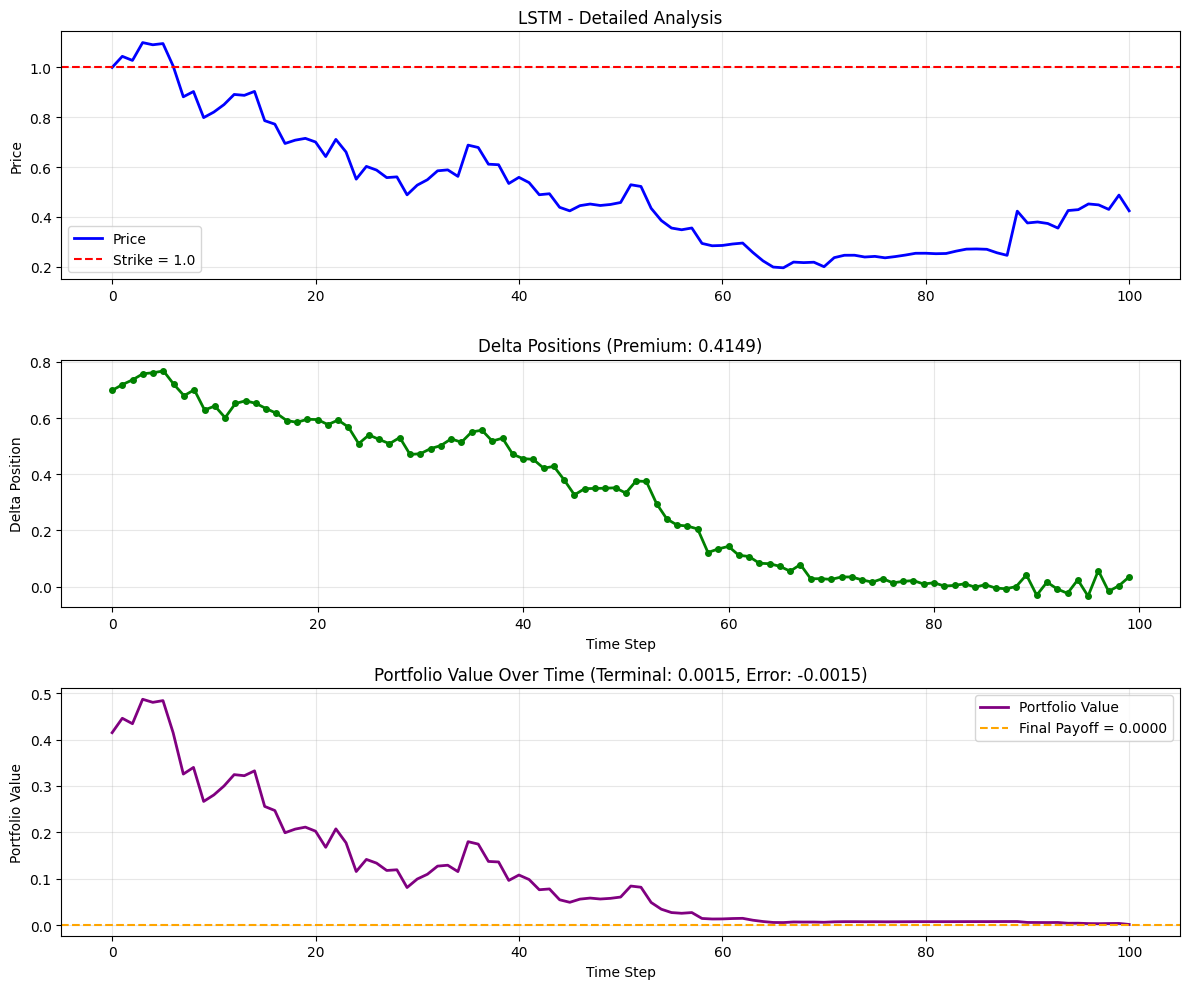

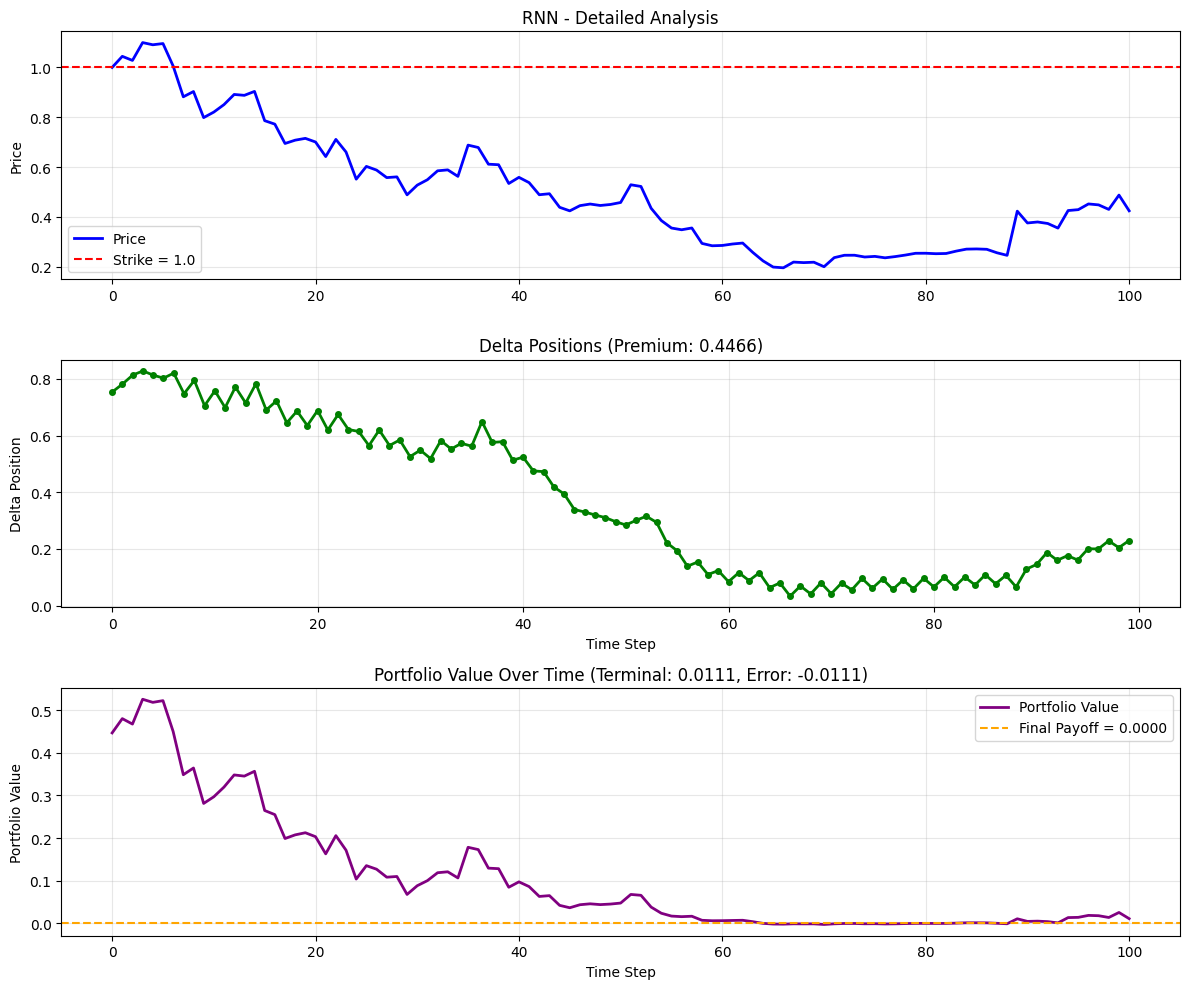

In [9]:
# Detailed analysis: plot price path, deltas, and portfolio value over time
selected_models = ['BlackScholes', 'DeltaGamma', 'LinearRegression', 'XGBoost', 'FeedforwardLayers', 'FeedforwardTime', 'LSTM', 'RNN']
selected_models = [m for m in selected_models if m in evaluation_results and evaluation_results[m] is not None]

sample_idx = 10
sample_prices = test_prices[sample_idx:sample_idx+1]

for name in selected_models:
    model = models[name]
    
    with torch.no_grad():
        deltas = model.forward(sample_prices)
        terminal_value = model.compute_terminal_value(sample_prices, deltas)
        final_price = sample_prices[0, -1]
        payoff = model.compute_payoff(final_price.unsqueeze(0))
    
    prices_np = sample_prices[0].cpu().numpy()
    deltas_np = deltas[0].cpu().numpy()
    premium = evaluation_results[name]['premium']
    
    # Compute portfolio value over time
    portfolio_values = [premium]  # Start with premium
    for t in range(seq_length):
        price_change = prices_np[t+1] - prices_np[t]
        portfolio_values.append(portfolio_values[-1] + deltas_np[t] * price_change)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Plot 1: Price path
    axes[0].plot(np.arange(seq_length+1), prices_np, 'b-', linewidth=2, label='Price')
    axes[0].axhline(y=strike, color='r', linestyle='--', label=f'Strike = {strike}')
    axes[0].set_ylabel('Price')
    axes[0].set_title(f'{name} - Detailed Analysis')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Delta positions
    axes[1].plot(np.arange(seq_length), deltas_np, 'g-', linewidth=2, marker='o', markersize=4)
    axes[1].set_ylabel('Delta Position')
    axes[1].set_xlabel('Time Step')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title(f'Delta Positions (Premium: {premium:.4f})')
    
    # Plot 3: Portfolio value over time
    axes[2].plot(np.arange(seq_length+1), portfolio_values, 'purple', linewidth=2, label='Portfolio Value')
    axes[2].axhline(y=payoff.item(), color='orange', linestyle='--', label=f'Final Payoff = {payoff.item():.4f}')
    axes[2].set_ylabel('Portfolio Value')
    axes[2].set_xlabel('Time Step')
    axes[2].set_title(f'Portfolio Value Over Time (Terminal: {terminal_value.item():.4f}, Error: {(payoff - terminal_value).item():.4f})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook has:
1. ✅ Generated GBM price paths
2. ✅ Trained all hedging models (deep and non-deep)
3. ✅ Evaluated models on test data
4. ✅ Visualized price paths, delta positions, and premiums
5. ✅ Computed and compared replication errors

Key findings:
- **Premium**: Initial cost of the option
- **Delta Positions**: Hedging positions at each time step
- **Replication Error (X)**: Payoff - Terminal Value (should be close to 0 for good hedgers)
- **MSE of X**: Mean squared error of replication error (lower is better)
